In [1]:
import numpy as np
#import scipy.io as sio
import scipy.misc
from keras.preprocessing import image
from skimage.transform import rotate, resize
from skimage.measure import label, regionprops
from time import time
from utils_Mnet import pro_process, BW_img, disc_crop
import matplotlib.pyplot as plt
from skimage.io import imsave


import cv2
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import Model_DiscSeg as DiscModel
import Model_MNet as MNetModel

Using TensorFlow backend.


In [7]:
DiscROI_size = 400
DiscSeg_size = 640
CDRSeg_size = 400

train_data_type = '.jpg'
mask_data_type ='.bmp'

Original_validation_img_path = 'data/'

valiImage_save_path='data/save_path_460/'

PolarTrainImage_save_path='data/PolarTrainImage_save_path/'
seg_result_save_path = 'data/result_460/'

if not os.path.exists(seg_result_save_path):
    os.makedirs(seg_result_save_path)
    

if not os.path.exists(valiImage_save_path):
    os.makedirs(valiImage_save_path)        


if not os.path.exists(PolarTrainImage_save_path):
    os.makedirs(PolarTrainImage_save_path)   
    

In [8]:
file_train_list = [file for file in os.listdir(Original_validation_img_path) if file.lower().endswith(train_data_type)]
print(str(len(file_train_list)))

DiscSeg_model = DiscModel.DeepModel(size_set=DiscSeg_size)
DiscSeg_model.load_weights('Model_DiscSeg_ORIGA_pretrain.h5')

CDRSeg_model = MNetModel.DeepModel(size_set=CDRSeg_size)
CDRSeg_model.load_weights('Model_MNet_ORIGA_pretrain.h5')

7


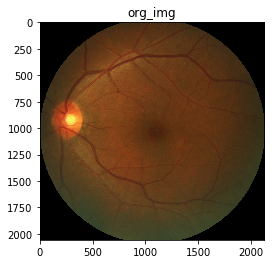

/anaconda2/envs/py3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda2/envs/py3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [ ]:
for lineIdx in range(0, len(file_train_list)):
    temp_txt = [elt.strip() for elt in file_train_list[lineIdx].split(',')]
    #print(' Processing Img: ' + temp_txt[0])
    # load image
    org_img = np.asarray(image.load_img(Original_validation_img_path + temp_txt[0]))
    plt.imshow(org_img)
    plt.title('org_img')
    plt.show()
    
#    nameLen=len(temp_txt[0])
#    org_mask = np.asarray(image.load_img(Original_Mask_img_path + temp_txt[0][:nameLen-4]+mask_data_type))[:,:,0]
 
    
#    org_disc = org_mask<255
#    plt.imshow(org_disc)
#    plt.title('org_disc')
#    plt.show()
#    
#    org_cup = org_mask==0
#    plt.imshow(org_cup)
#    plt.title('org_cup')
#    plt.show()
    
    # Disc region detection by U-Net
    temp_org_img = resize(org_img, (DiscSeg_size, DiscSeg_size, 3)) 
#    plt.imshow(temp_org_img)
#    plt.title('temp_org_img')
#    plt.show()
    
#    temp_org_disc = resize(org_disc, (DiscSeg_size, DiscSeg_size)) 
#    plt.imshow(temp_org_disc)
#    plt.title('temp_org_disc')
#    plt.show()
#    
#    temp_org_cup = resize(org_cup, (DiscSeg_size, DiscSeg_size)) 
#    plt.imshow(temp_org_cup)
#    plt.title('temp_org_cup')
#    plt.show()    
    
    temp_org_img = np.reshape(temp_org_img, (1,) + temp_org_img.shape)*255

    [prob_6, prob_7, prob_8, prob_9, prob_10] = DiscSeg_model.predict([temp_org_img])
    
    plt.imshow(np.squeeze(np.clip(prob_10*255,0,255).astype('uint8')))
    plt.title('temp_img')
    plt.show()
    
    org_img_disc_map = BW_img(np.reshape(prob_10, (DiscSeg_size, DiscSeg_size)), 0.5)
#    org_disc_bw = BW_img(np.reshape(temp_org_disc, (DiscSeg_size, DiscSeg_size)), 0.5)    
#    org_cup_bw = BW_img(np.reshape(temp_org_cup, (DiscSeg_size, DiscSeg_size)), 0.5)  
    
    regions = regionprops(label(org_img_disc_map))

    
    C_x = int(regions[0].centroid[0] * org_img.shape[0] / DiscSeg_size)
    C_y = int(regions[0].centroid[1] * org_img.shape[1] / DiscSeg_size)
    org_img_disc_region, err_coord, crop_coord = disc_crop(org_img, DiscROI_size, C_x, C_y)
#    org_disc_region, err_coord_disc, crop_coord_disc =disc_crop(org_disc, DiscROI_size, C_x, C_y)
#    org_cup_region, err_coord_cup, crop_coord_cup =disc_crop(org_cup, DiscROI_size, C_x, C_y)

    plt.imshow(org_img_disc_region)
    plt.title('org_img_disc_region')
    plt.show()
    
#    plt.imshow(org_disc_region)
#    plt.title('org_disc_region')
#    plt.show()
#
#    plt.imshow(org_cup_region)
#    plt.title('org_cup_region')
#    plt.show()
    # Disc and Cup segmentation by M-Net
    run_time_start = time()
    Org_img_Disc_flat = rotate(cv2.linearPolar(org_img_disc_region, (DiscROI_size/2, DiscROI_size/2), DiscROI_size/2, cv2.WARP_FILL_OUTLIERS), -90)
    
#    plt.imshow(Org_img_Disc_flat)
#    plt.title('Org_img_Disc_flat')
#    plt.show()
    
    temp_img = pro_process(Org_img_Disc_flat, CDRSeg_size)
    temp_img = np.reshape(temp_img, (1,) + temp_img.shape)
    [prob_6, prob_7, prob_8, prob_9, prob_10] = CDRSeg_model.predict(temp_img)
    
    
 
    
    run_time_end = time()

    # Extract mask
    prob_map = np.reshape(prob_10, (prob_10.shape[1], prob_10.shape[2], prob_10.shape[3]))
    disc_map = scipy.misc.imresize(prob_map[:, :, 0], (DiscROI_size, DiscROI_size))
#    plt.imshow(disc_map)
#    plt.title('disc_map')
#    plt.show()
    cup_map = scipy.misc.imresize(prob_map[:, :, 1], (DiscROI_size, DiscROI_size))
#    plt.imshow(cup_map)
#    plt.title('cup_map')
#    plt.show()
    disc_map[-round(DiscROI_size / 3):, :] = 0
    cup_map[-round(DiscROI_size / 2):, :] = 0
    De_disc_map = cv2.linearPolar(rotate(disc_map, 90), (DiscROI_size/2, DiscROI_size/2),
                                      DiscROI_size/2, cv2.WARP_FILL_OUTLIERS + cv2.WARP_INVERSE_MAP)
    plt.imshow(De_disc_map)
    plt.title('De_disc_map')
    plt.show()


    De_cup_map = cv2.linearPolar(rotate(cup_map, 90), (DiscROI_size/2, DiscROI_size/2),
                                     DiscROI_size/2, cv2.WARP_FILL_OUTLIERS + cv2.WARP_INVERSE_MAP)
    
    plt.imshow(De_cup_map)
    plt.title('De_cup_map')
    plt.show()
    
    De_disc_map = np.array(BW_img(De_disc_map, 0.5), dtype=int)
    plt.imshow(De_disc_map)
    plt.title('BW De_disc_map')
    plt.show()    
    
    De_cup_map = np.array(BW_img(De_cup_map, 0.5), dtype=int)
    plt.imshow(De_cup_map)
    plt.title('BW De_cup_map')
    plt.show()  

    print(' Run time MNet: ' + str(run_time_end - run_time_start) + '   Img number: ' + str(lineIdx + 1))

    # Save mask
    ROI_result = np.array(BW_img(De_disc_map, 0.5), dtype=int) + np.array(BW_img(De_cup_map, 0.5), dtype=int)
    
    plt.imshow(ROI_result)
    plt.title('ROI_result')
    plt.show()     
    
    
    Img_result = np.zeros((org_img.shape[0],org_img.shape[1]), dtype=int)
    Img_result[crop_coord[0]:crop_coord[1], crop_coord[2]:crop_coord[3], ] = ROI_result[err_coord[0]:err_coord[1], err_coord[2]:err_coord[3], ]

    plt.imshow(Img_result)
    plt.title('Img_result')
    plt.show() 

#    sio.savemat(seg_result_save_path + temp_txt[0][:-4] + '.mat', {'Img_map': np.array(Img_result, dtype=np.uint8), 'ROI_map': np.array(ROI_result, dtype=np.uint8)})

    imsave(valiImage_save_path+temp_txt[0],org_img_disc_region)
    


    
    imsave(PolarTrainImage_save_path+temp_txt[0],Org_img_Disc_flat)
    
    
    Img_result=Img_result /Img_result.max()
    Img_result=255*Img_result
    Img_result=Img_result.astype(np.uint8)
    Img_result[Img_result==255]=200
    Img_result[Img_result==0]=255   
    Img_result[Img_result==200]=0   
    Img_result[(Img_result<200) & (Img_result>0)]=128  
    imsave(seg_result_save_path+temp_txt[0],(Img_result))   
 